# Multi-trajectory workflow to Run CV for CO Stripping.

Author: 

Joel W. Ager (jwager@lbl.gov, [ORCID](https://orcid.org/0000-0001-9334-9751)) [Group website](http://ager.mse.berkeley.edu), [GitHub](https://github.com/joelager)

Jinghan Li (mseljh@sjtu.edu.cn, [ORCID](https://orcid.org/0000-0003-3619-5121))

# Import packages

In [1]:
# files handling
import os
import shutil
import glob          # So wild cards can be used
from pathlib import Path  # for platform independence, converts / to \ b

# Code from the Zacros authors, must be in a subfolder of the code containing this notebook
import zacros_wrapper as zw

# data analysis
import pandas as pd
import numpy as np
from units import * # # Python script with SI units, cgs conversions, and physical constants # added the units conversion to the units.py

# plot curves
from IPython.display import Image # For looking at png files in the notebook
import matplotlib.pyplot as plt    

# Set parameters and the directory
Set the directory with the notebook and the one with the zacros input files for forward sweep.

In [2]:
notebook_wd = Path('C:/Users/mselj/Desktop/Paper/Paper-KMC/Upload-notebooks+simulation-files')
zacros_relative_file_location = Path('04-CV-Multi-SF')
zacros_wd = os.path.join(notebook_wd, zacros_relative_file_location)

################################## set the number of trajectories and other parameters #########################################
n_trajectory = 10
n_sites = 2500
IniCov = 0.5
################################################################################################################################

T = 300*kelvin
Eoffset = 10 * volt
Γ_sites = 1.32e15 * cm**-2

In [3]:
os.chdir(zacros_wd)
glob.glob('*.dat')   # should list the 5 .dat files # later can use this to copy the files.

['energetics_input.dat',
 'lattice_input.dat',
 'mechanism_input.dat',
 'simulation_input.dat',
 'state_input.dat']

# Construct the run object, check input files

In [4]:
# multi_1 for KMC run
multi_1 = zw.KMC_Run.kmc_traj(path=zacros_wd)
multi_1.ReadAllInput()

# multi_0 for IO
multi_0 = zw.IO_data.SimIn()
multi_0.ReadIn(zacros_wd)

E_start = round(multi_0.TPD_start-Eoffset,1)
E_sr = multi_0.TPD_ramp/(mV/sec)
Time = multi_0.SimTime_Max
E_end = round(E_start+multi_0.TPD_ramp*Time,1)

print('Run exists: ', multi_1.CheckComplete())  # will be false if simulation has not run yet 
print('Number of surface species: {:d}'.format(multi_1.simin.n_surf))
print('Simulation time: {:.3f} seconds'.format(multi_1.simin.SimTime_Max))
print('Lattice occupancy maps written every {:.3f} seconds'.format(multi_1.simin.hist[1]))
print('Process statistics written every {:.3f} seconds'.format(multi_1.simin.procstat[1]))
print('Species numbers written every {:.3f} seconds'.format(multi_1.simin.specnum[1]))
n_data_species = int(multi_1.simin.SimTime_Max/multi_1.simin.specnum[1] + 1)
print('Species numbers written {:d} times per trajectory'.format(n_data_species))

Run exists:  False
Number of surface species: 2
Simulation time: 8.000 seconds
Lattice occupancy maps written every 0.100 seconds
Process statistics written every 0.100 seconds
Species numbers written every 0.100 seconds
Species numbers written 81 times per trajectory


In [5]:
# get cluster information
Spec_Name = multi_0.surf_spec
n_spec = len(Spec_Name)
print (Spec_Name)
print (n_spec)

['CO*', 'OH*']
2


In [6]:
# The function for running KMC
def Run (zacros_wd):
    cwd = os.getcwd()
    os.chdir(zacros_wd)
    os.getcwd()
    os.system('wsl.exe zacros-s.x')
    os.chdir(cwd)
    return 

In [7]:
# The function for running CV, directory is needed
def CV (zacros_wd):
    Run(zacros_wd)
    shutil.copytree(zacros_wd,os.path.join(zacros_wd,'F'))
    
   
    # Get information from the last snapshot
    His = zw.IO_data.HistoryOut()
    His.ReadOut(zacros_wd,n_sites)
    temp = pd.DataFrame(His.snapshots[-1]) # Read the last snapshot.
    temp.rename(columns={0: 'site', 1: 'identifier', 2:'species', 3:'dentate number'}, inplace=True)
#     print (temp)
    
    
    # Change E-start, ramp and write the state_input files.
    SimIn = zw.IO_data.SimIn()
    SimIn.ReadIn(zacros_wd)
    Time = SimIn.SimTime_Max
    SimIn.TPD_start = round(SimIn.TPD_start+SimIn.TPD_ramp*Time,1)
    SimIn.TPD_ramp = - SimIn.TPD_ramp
    SimIn.WriteIn(zacros_wd)
    
    # write the state_input files. For adsorbate only on single site.
    with open(os.path.join(zacros_wd,'state_input.dat'),'w') as f:
        f.write('initial_state\n')
        for i in range (n_spec):
            tempdf= np.array(temp[temp['species'] == i+1])
            templist = tempdf[:,0]
            for j in range (len(templist)):
                f.write('seed_on_sites {} {} \n'.format (Spec_Name[i], templist[j]))
        f.write('end_initial_state\n')
          
#     # write the state_input files. For bidentate. Needed for Goodpaster model.
#     with open(os.path.join(zacros_wd,'state_input.dat'),'w') as f:
#         f.write('initial_state\n')
#         temp1= np.array(temp[temp['dentate number'] == 2]) # Search for bidentate
#         temp1_n = len(temp1)
#         for n in range (temp1_n): # for each one, create a new temp list, write in the input file, remove from the original dataframe
#             tempidentifier = temp1[n,1]
#             print (tempidentifier)
#             temp2 = temp.loc[temp['identifier'] == tempidentifier]
#             print(temp2)
#             f.write('seed_on_sites {} {} {}\n'.format (Spec_Name [temp2.iat[0,2]-1], temp2.iat[0,0], temp2.iat[1,0]))
#             temp.drop(temp[temp['identifier'] == tempidentifier].index, inplace = True)
#         print(temp)
#         for i in range (n_spec):
#             tempdf= np.array(temp[temp['species'] == i+1])
#             templist = tempdf[:,0]
#             for j in range (len(templist)):
#                 f.write('seed_on_sites {} {} \n'.format (Spec_Name[i], templist[j]))
#         f.write('end_initial_state\n')
    
    
    # Run backword and save
    Run (zacros_wd)
    shutil.copytree(zacros_wd,os.path.join(zacros_wd,'B'))

    # copy back the original input files
    shutil.copy(os.path.join(zacros_wd,'F/state_input.dat'), os.path.join(zacros_wd,'state_input.dat'))
    shutil.copy(os.path.join(zacros_wd,'F/simulation_input.dat'), os.path.join(zacros_wd,'simulation_input.dat'))

In [8]:
# The function for calculating coverage , return Dataframe   
def Coverage():
    # Set path and read data
    PathF = os.path.join(zacros_wd,'F')
    PathB = os.path.join(zacros_wd,'B')
    SpecOut = zw.IO_data.SpecnumOut()
    SpecOutB = zw.IO_data.SpecnumOut()
    SpecOut.ReadOut(PathF)
    SpecOutB.ReadOut(PathB)
    
    # Combine the specnum data
    Spec = np.append (SpecOut.spec, SpecOutB.spec, axis = 0)
    Potential = np.append (SpecOut.T, SpecOutB.T, axis = 0)
    Timer = np.append (SpecOut.t, SpecOutB.t+Time, axis = 0)

    SpecN = Timer.shape[0]
    tempPotential = Potential.reshape (SpecN,1)
    tempTimer = Timer.reshape (SpecN,1)
    tempdf = np.concatenate([tempTimer, tempPotential-Eoffset, Spec], axis = 1)
    dfSpec = pd.DataFrame(tempdf) # change arrays to Dataframe.
    
    ############################ remember to change for different type of simulations. ###################################################
    dfSpec.rename(columns={0: 'Time', 1:'Potential', 2: 'CO*', 3: 'OH*', 4: 'OH', 5: 'CO2'}, inplace=True)
    ############################ remember to change for different type of simulations. ###################################################

    return dfSpec

In [9]:
 # The function for calculating current and setting it into a numpy array.
def Current():
    
    # Set path and read data
    PathF = os.path.join(zacros_wd,'F')
    PathB = os.path.join(zacros_wd,'B')
    SimIn = zw.IO_data.SimIn()
    SimIn.ReadIn(PathF)
    ProOut = zw.IO_data.ProcstatOut()
    ProOut.ReadOut(PathF)
    ProOutB = zw.IO_data.ProcstatOut()
    ProOutB.ReadOut(PathB)

    ProcN = ProOut.t.shape[0]
    tempT = ProOut.t.reshape (ProcN,1) # change the array of t into 2D array
    tempF = np.concatenate([E_start+tempT*SimIn.TPD_ramp, ProOut.events], axis = 1) # merge the 2 arrays
    tempB = np.concatenate([E_end-tempT*SimIn.TPD_ramp, ProOutB.events], axis = 1) # merge the 2 arrays
    tempdf = np.append (tempF, tempB, axis = 0)
    df = pd.DataFrame(tempdf) # change arrays to Dataframe.
    df.rename(columns={0: 'Potential', 1: 'OH_adsorption', 2: 'OH_desorption', 3: 'CO_oxidation', 4: 'CO_diffusion'},
                      inplace=True)
    
    # calculate current
    df["abs"] = df.apply(lambda x: x["OH_adsorption"] - x["OH_desorption"] + x["CO_oxidation"], axis=1) #charge changes before setted time
    df['+'] = df['abs'] - df['abs'].shift(1) # charge changes per 0.01s'
    df['current'] = df['+']*q*Γ_sites/(SimIn.procstat[1]*n_sites*mA*cm**-2)
    df.loc[ProcN]['current'] = None

    # write current into a numpy array
    current = np.array(df['current'])
    return current

In [10]:
# Run multiple trajectories
print('**Beginning {:d} trajectories**'.format(n_trajectory))

for i in range(n_trajectory):
    print('Starting trajectory', i + 1)
    CV (zacros_wd) # output files save in F/B folders
    print('finished trajectory:', multi_1.CheckComplete())
    Spec_out = Coverage() # store the dataframe to coverage ##### test the type of Spec_out

    ############################ remember to change for different type of simulations. ###################################################
    if i == 0: # Make new arrays the first time through
        t_multi = np.array(Spec_out ['Time'])
        E_multi = np.array(Spec_out ['Potential']) 
        CO_vs_time = np.array(Spec_out ['CO*'])  
        OH_vs_time = np.array(Spec_out ['OH*'])
        current_vs_time = Current() ##### current here

    else:
        CO_vs_time = np.vstack((CO_vs_time, np.array(Spec_out ['CO*'])))
        OH_vs_time = np.vstack((OH_vs_time, np.array(Spec_out ['OH*'])))
        current_vs_time = np.vstack((current_vs_time, Current()))
    ############################ remember to change for different type of simulations. ###################################################
    # delete folders F and B after run
    shutil.rmtree(os.path.join(zacros_wd,'F'))
    shutil.rmtree(os.path.join(zacros_wd,'B'))
    
print('**finished simulation run**')

**Beginning 10 trajectories**
Starting trajectory 1
finished trajectory: True
Starting trajectory 2
finished trajectory: True
Starting trajectory 3
finished trajectory: True
Starting trajectory 4
finished trajectory: True
Starting trajectory 5
finished trajectory: True
Starting trajectory 6
finished trajectory: True
Starting trajectory 7
finished trajectory: True
Starting trajectory 8
finished trajectory: True
Starting trajectory 9
finished trajectory: True
Starting trajectory 10
finished trajectory: True
**finished simulation run**


In [11]:
# save the files 
############################ remember to change for different type of simulations. ###################################################
np.savetxt("CO_vs_time.csv", CO_vs_time, delimiter=',')  # n rows
np.savetxt("OH_vs_time.csv", OH_vs_time, delimiter=',')  # n rows
np.savetxt("current_vs_time.csv", current_vs_time, delimiter=',')  # n rows
np.savetxt("E_multi.csv", E_multi, delimiter=',')  # 1 colume
np.savetxt("t_multi.csv", t_multi, delimiter=',')  # 1 colume
############################ remember to change for different type of simulations. ###################################################

# Make some plots

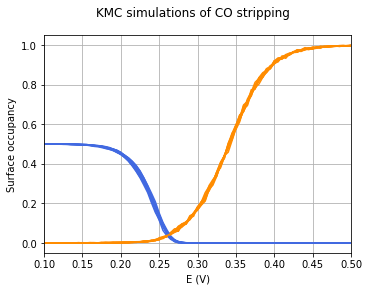

In [12]:
# overlap trajectories
fig, ax = plt.subplots(figsize=(5.5,4))
fig.suptitle('KMC simulations of CO stripping')
for i in range(n_trajectory):

    plt.plot(np.split(E_multi,2)[0], np.split(CO_vs_time[i]/n_sites,2)[0],'royalblue')  # Forward
#     plt.plot(np.split(E_multi,2)[1], np.split(CO_vs_time[i]/n_sites,2)[1], 'plum', '--',linewidth=0.5)  # Backward
    plt.plot(np.split(E_multi,2)[0], np.split(OH_vs_time[i]/n_sites,2)[0],'darkorange')
#     plt.plot(np.split(E_multi,2)[1], np.split(OH_vs_time[i]/n_sites,2)[1], 'skyblue','--',linewidth=0.5)

ax.set_ylabel('Surface occupancy')
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('E (V)')
ax.set_xlim(min(E_start, E_end), max(E_start, E_end))
ax.grid()
fig.savefig(os.path.join(zacros_wd,'coverage-multi.png'),dpi=600,format='png')

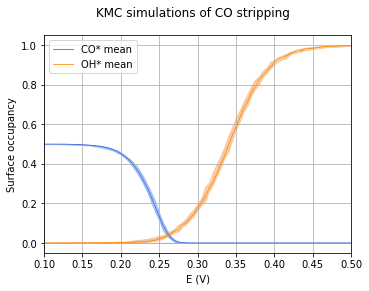

In [13]:
fig, ax = plt.subplots(figsize=(5.5,4))
fig.suptitle('KMC simulations of CO stripping')
# To look clear, only forward sweep plotted here
ax.plot(np.split(E_multi,2)[0], np.split(np.mean(CO_vs_time, axis=0)/n_sites,2)[0],'royalblue', linewidth=0.8, label='CO* mean')
ax.plot(np.split(E_multi,2)[0], np.split(np.mean(OH_vs_time, axis=0)/n_sites,2)[0],'darkorange', linewidth=0.8, label='OH* mean')
ax.fill_between(E_multi,
               np.amax(CO_vs_time/n_sites, axis=0),
               np.amin(CO_vs_time/n_sites, axis=0),
               color='cornflowerblue', alpha=0.5)
ax.fill_between(E_multi,
               np.amax(OH_vs_time/n_sites, axis=0),
               np.amin(OH_vs_time/n_sites, axis=0),
               color='sandybrown', alpha=0.5)

ax.set_ylabel('Surface occupancy')
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('E (V)')
ax.set_xlim(min(E_start, E_end), max(E_start, E_end))

ax.legend()
ax.grid()
fig.savefig(os.path.join(zacros_wd,'coverage-mean.png'),dpi=600,format='png')

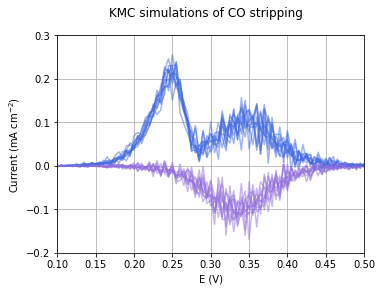

In [14]:
# overlap trajectories
fig, ax = plt.subplots(figsize=(5.5,4))
fig.suptitle('KMC simulations of CO stripping')
for i in range(n_trajectory):
    plt.plot(np.split(E_multi,2)[0], np.split(current_vs_time[i],2)[0], 'royalblue',alpha = 0.5)
    plt.plot(np.split(E_multi,2)[1], np.split(current_vs_time[i],2)[1], 'mediumpurple',alpha = 0.5)
    
ax.set_ylabel('Current (mA cm$^{-2}$)')
ax.set_ylim(-0.2, 0.3)
ax.set_xlabel('E (V)')
ax.set_xlim(min(E_start, E_end), max(E_start, E_end))

ax.grid()
fig.savefig(os.path.join(zacros_wd,'current-multi.png'),dpi=600,format='png')

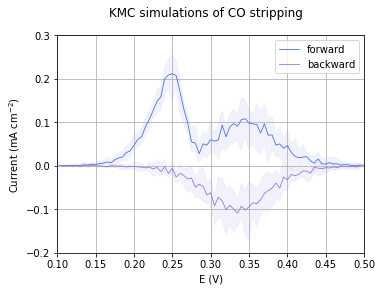

In [15]:
fig, ax = plt.subplots(figsize=(5.5,4))
fig.suptitle('KMC simulations of CO stripping')
ax.plot(np.split(E_multi,2)[0], np.split(np.mean(current_vs_time, axis=0),2)[0],'royalblue', linewidth=0.8, label='forward')
ax.plot(np.split(E_multi,2)[1], np.split(np.mean(current_vs_time, axis=0),2)[1],'mediumpurple', linewidth=0.8, label='backward')

ax.fill_between(E_multi,
               np.amax(current_vs_time, axis=0),
               np.amin(current_vs_time, axis=0),
               color='lavender', alpha = 0.5)

ax.set_ylabel('Current (mA cm$^{-2}$)')
ax.set_ylim(-0.2, 0.3)
ax.set_xlabel('E (V)')
ax.set_xlim(min(E_start, E_end), max(E_start, E_end))

ax.legend()
ax.grid()
fig.savefig(os.path.join(zacros_wd,'current-mean.png'),dpi=600,format='png')

Shaded regions shows minimum and maximum.